In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import winsound
from scipy.spatial.transform import Rotation as R
from numpy import genfromtxt
import time

frequency = 500  # Set Frequency To 2500 Hertz
duration = 1000  # Set Duration To 1000 ms == 1 second
winsound.Beep(frequency, duration)

In [6]:
# load data

import glob
import os

normal_path = r'data_LSTM\normal'
normal_files = glob.glob(os.path.join(normal_path, "*.csv"))
valid_path = r'data_LSTM\valid'
valid_files = glob.glob(os.path.join(valid_path, "*.csv"))
engine_path = r'data_LSTM\engine'
engine_files = glob.glob(os.path.join(engine_path, "*.csv"))
elevator_path = r'data_LSTM\elevator'
elevator_files = glob.glob(os.path.join(elevator_path, "*.csv"))
rudder_path = r'data_LSTM\rudder'
rudder_files = glob.glob(os.path.join(rudder_path, "*.csv"))
state_input_dim = 17
state_dim = 10
remove_step = 32 # It takes 8 seconds (=32steps) for the model to become stable (ICRA paper Section V.B)

In [7]:
def data_preprocessing(seq2): 
    a,b = seq2.shape
    seq = np.zeros((a,b-1))
    seq[:, 0:3] = seq2[:, 3:6]
    seq[:, 7:13] = seq2[:, 9:15]
    seq[:,17:23] = seq2[:,18:24]
    for k in range(a): # change Euler angle into quaternion
        r = R.from_euler('xyz', [seq2[k,6:9]], degrees=True)
        seq[k, 3:7] = r.as_quat()
        r = R.from_euler('xyz', [seq2[k,15:18]], degrees=True)
        seq[k, 13:17] = r.as_quat()
    return seq[remove_step:, :]

In [8]:
normal_num = len(normal_files)
for i in range(normal_num):
    seq2 = genfromtxt(normal_files[i], delimiter=',')
    seq = data_preprocessing(seq2)
    if i == 0:
        normal_total_data = seq[:, :state_input_dim]
    else:
        normal_total_data = np.append(normal_total_data, seq[:, :state_input_dim], axis=0)

normal_mean = np.mean(normal_total_data, axis=0)
normal_std = np.std(normal_total_data, axis=0)

In [9]:
# normal data preprocessing
def RNN_set_making(files, window):
    file_num = len(files)
    seq_length = np.zeros(file_num, dtype=int)
    for i in range(file_num):
        seq2 = genfromtxt(files[i], delimiter=',')
        seq = data_preprocessing(seq2)
        a, b = seq.shape
        seq[:, :state_input_dim] = (seq[:, :state_input_dim] - normal_mean)/normal_std
        seq_length[i] = a
        for j in range(a - window):
            if i == 0 and j == 0:
                X = np.expand_dims(seq[j:j+window, :state_input_dim], axis=0)
                Y = np.expand_dims(seq[j+window, :state_dim], axis=0)
                label = np.expand_dims(seq[j+window, state_input_dim:], axis=0)
            else:
                X = np.append(X, np.expand_dims(seq[j:j+window, :state_input_dim], axis=0), axis=0)
                Y = np.append(Y, np.expand_dims(seq[j+window, :state_dim], axis=0), axis=0)
                label = np.append(label, np.expand_dims(seq[j+window, state_input_dim:], axis=0), axis=0) 
    return X, Y, label, seq_length, file_num

# 2. Network training

In [20]:
## Custom learning rate
initial_learning_rate = 0.01
def lr_step_decay(epoch, lr):
    drop_rate = 0.5
    epochs_drop = 22.0
    return initial_learning_rate * tf.math.pow(drop_rate, tf.math.floor(epoch/epochs_drop))

lr_scheduler = keras.callbacks.LearningRateScheduler(lr_step_decay)

In [23]:
for window in range(3,17):
    print('L='+str(window)+'\n')
    normal_X, normal_Y, normal_label, normal_seq_length, normal_num = RNN_set_making(normal_files, window)
    valid_X, valid_Y, valid_label, valid_seq_length, valid_num = RNN_set_making(valid_files, window)
    model = keras.models.Sequential([
        keras.layers.LSTM(64, return_sequences=True, input_shape=(None, 17)),
        keras.layers.LSTM(64, return_sequences=True),
        keras.layers.LSTM(64, return_sequences=True),
        keras.layers.LSTM(32, return_sequences=True),
        keras.layers.LSTM(32, return_sequences=False),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dropout(0.1),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dropout(0.1),
        keras.layers.Dense(10)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='models_L\\20220113_L='+str(window)+'_model.{epoch:02d}-{val_loss:.4f}.h5', save_best_only=True) # , save_best_only=True
    model.fit(normal_X, normal_Y, epochs=100, batch_size=128, 
              validation_data = (valid_X, valid_Y), callbacks = [model_checkpoint_callback, lr_scheduler])
    winsound.Beep(frequency, duration)

# For each window(L in the paper), save the model with the lowest validation loss
# Choose the model with the lowest lowest validation loss
# L = 4 in this case

L=3

Epoch 1/100
60/60 [==============================] - 2s 32ms/step - loss: 0.5632 - val_loss: 0.3783
Epoch 2/100
60/60 [==============================] - 0s 7ms/step - loss: 0.3458 - val_loss: 0.3037
Epoch 3/100
60/60 [==============================] - 0s 7ms/step - loss: 0.3147 - val_loss: 0.3082
Epoch 4/100
60/60 [==============================] - 0s 7ms/step - loss: 0.2864 - val_loss: 0.2564
Epoch 5/100
60/60 [==============================] - 0s 7ms/step - loss: 0.2643 - val_loss: 0.2417
Epoch 6/100
60/60 [==============================] - 0s 7ms/step - loss: 0.2484 - val_loss: 0.2233
Epoch 7/100
60/60 [==============================] - 0s 7ms/step - loss: 0.2249 - val_loss: 0.2225
Epoch 8/100
60/60 [==============================] - 0s 7ms/step - loss: 0.2166 - val_loss: 0.1966
Epoch 9/100
60/60 [==============================] - 0s 6ms/step - loss: 0.2058 - val_loss: 0.1989
Epoch 10/100
60/60 [==============================] - 0s 7ms/step - loss: 0.2036 - val_loss: 0.1842
Epo

KeyboardInterrupt: 

# 3. Test

In [10]:
model = keras.models.load_model('20220113_L=4_model.47-0.1205.h5') # load the model (L=4)

In [11]:
window=4 # input series length L
normal_X, normal_Y, normal_label, normal_seq_length, normal_num = RNN_set_making(normal_files, window)
valid_X, valid_Y, valid_label, valid_seq_length, valid_num = RNN_set_making(valid_files, window)
engine_X, engine_Y, engine_label, engine_seq_length, engine_num = RNN_set_making(engine_files, window)
elevator_X, elevator_Y, elevator_label, elevator_seq_length, elevator_num = RNN_set_making(elevator_files, window)
rudder_X, rudder_Y, rudder_label, rudder_seq_length, rudder_num = RNN_set_making(rudder_files, window)

In [119]:
def find_residual(pred, Y, num, seq_length, beta):
    a, b = pred.shape
    residual = np.zeros(a)
    index = 0
    for i in range(num):
        for j in range(seq_length[i] - window):
            difference = Y[index,:] - pred[index,:]
            if j == 0:
                residual[index] = np.linalg.norm(difference)
            else:
                residual[index] = beta * residual[index-1] + (1-beta)*np.linalg.norm(difference)
            index = index + 1
    return residual 

def plot_normal_residual(num, seq_length, residual, Threshold, figure_size):
    fig, axs = plt.subplots(num, figsize=figure_size)
    index = 0
    for i in range(num):
        axs[i].set(ylim=(0, 4))
        axs[i].plot(np.array(range(seq_length[i] - window)), residual[index : index + seq_length[i] - window],
                    np.array(range(seq_length[i] - window)), Threshold*np.ones(seq_length[i] - window))
        axs[i].set_title('Graph=' + str(i))
        index = index + seq_length[i] - window
        
def plot_fault_residual(num, seq_length, residual, label, Threshold, figure_size):
    engine_label2 = np.sum(label[:,1:], axis=1)
    fig, axs = plt.subplots(num, figsize=figure_size)
    index = 0
    for i in range(num):
        axs[i].set(ylim=(0, 4))
        axs[i].plot(np.array(range(seq_length[i] - window)), residual[index : index + seq_length[i] - window], 
                    np.array(range(seq_length[i] - window)), Threshold*engine_label2[index : index + seq_length[i] - window],
                    np.array(range(seq_length[i] - window)), Threshold*np.ones(seq_length[i] - window))
        axs[i].set_title('Graph=' + str(i))
        index = index + seq_length[i] - window
        
def save_plot_fault_residual(num, seq_length, residual, label, Threshold, plot_num):
    engine_label2 = np.sum(label[:,1:], axis=1)
    index = 0
    for i in range(num):
        if i == plot_num:
            np.savetxt('fault.txt', np.concatenate((np.expand_dims(0.25*np.array(range(seq_length[i] - window)), axis=1), 
                                                   np.expand_dims(residual[index : index + seq_length[i] - window], axis=1),
                                                   np.expand_dims(np.array(Threshold*engine_label2[index : index + seq_length[i] - window]), axis=1),
                                                   np.expand_dims(Threshold*np.ones(seq_length[i] - window), axis=1)), axis=1), delimiter=',')
                                                  
        index = index + seq_length[i] - window

In [107]:
# Find the best beta
length = 271
beta_list = np.zeros((length,1))
Threshold_list = np.zeros((length,1))
T_re = np.zeros((length,1))
for i in range(length):
    beta_list[i] = 0.7 + 0.001*i
    valid_pred = model.predict(valid_X)
    valid_residual = find_residual(valid_pred, valid_Y, valid_num, valid_seq_length, beta_list[i])
    Threshold_list[i] = np.mean(valid_residual) + 3.291 * np.std(valid_residual)
    max_residual = max(valid_residual)
    T_re[i] = abs(Threshold_list[i] - max_residual)
argmin = (T_re==min(T_re))
print("beta={:.4f}, T={:.4f}".format(float(beta_list[argmin]), float(Threshold_list[argmin])))

beta=0.9160, T=1.9941


In [108]:
# Save beta in txt
np.savetxt('beta.txt', np.concatenate((beta_list, T_re), axis=1), delimiter=',')

In [109]:
beta = float(beta_list[argmin])
valid_pred = model.predict(valid_X)
valid_residual = find_residual(valid_pred, valid_Y, valid_num, valid_seq_length, beta)
Threshold = np.mean(valid_residual) + 3.291 * np.std(valid_residual)
max_residual = max(valid_residual)

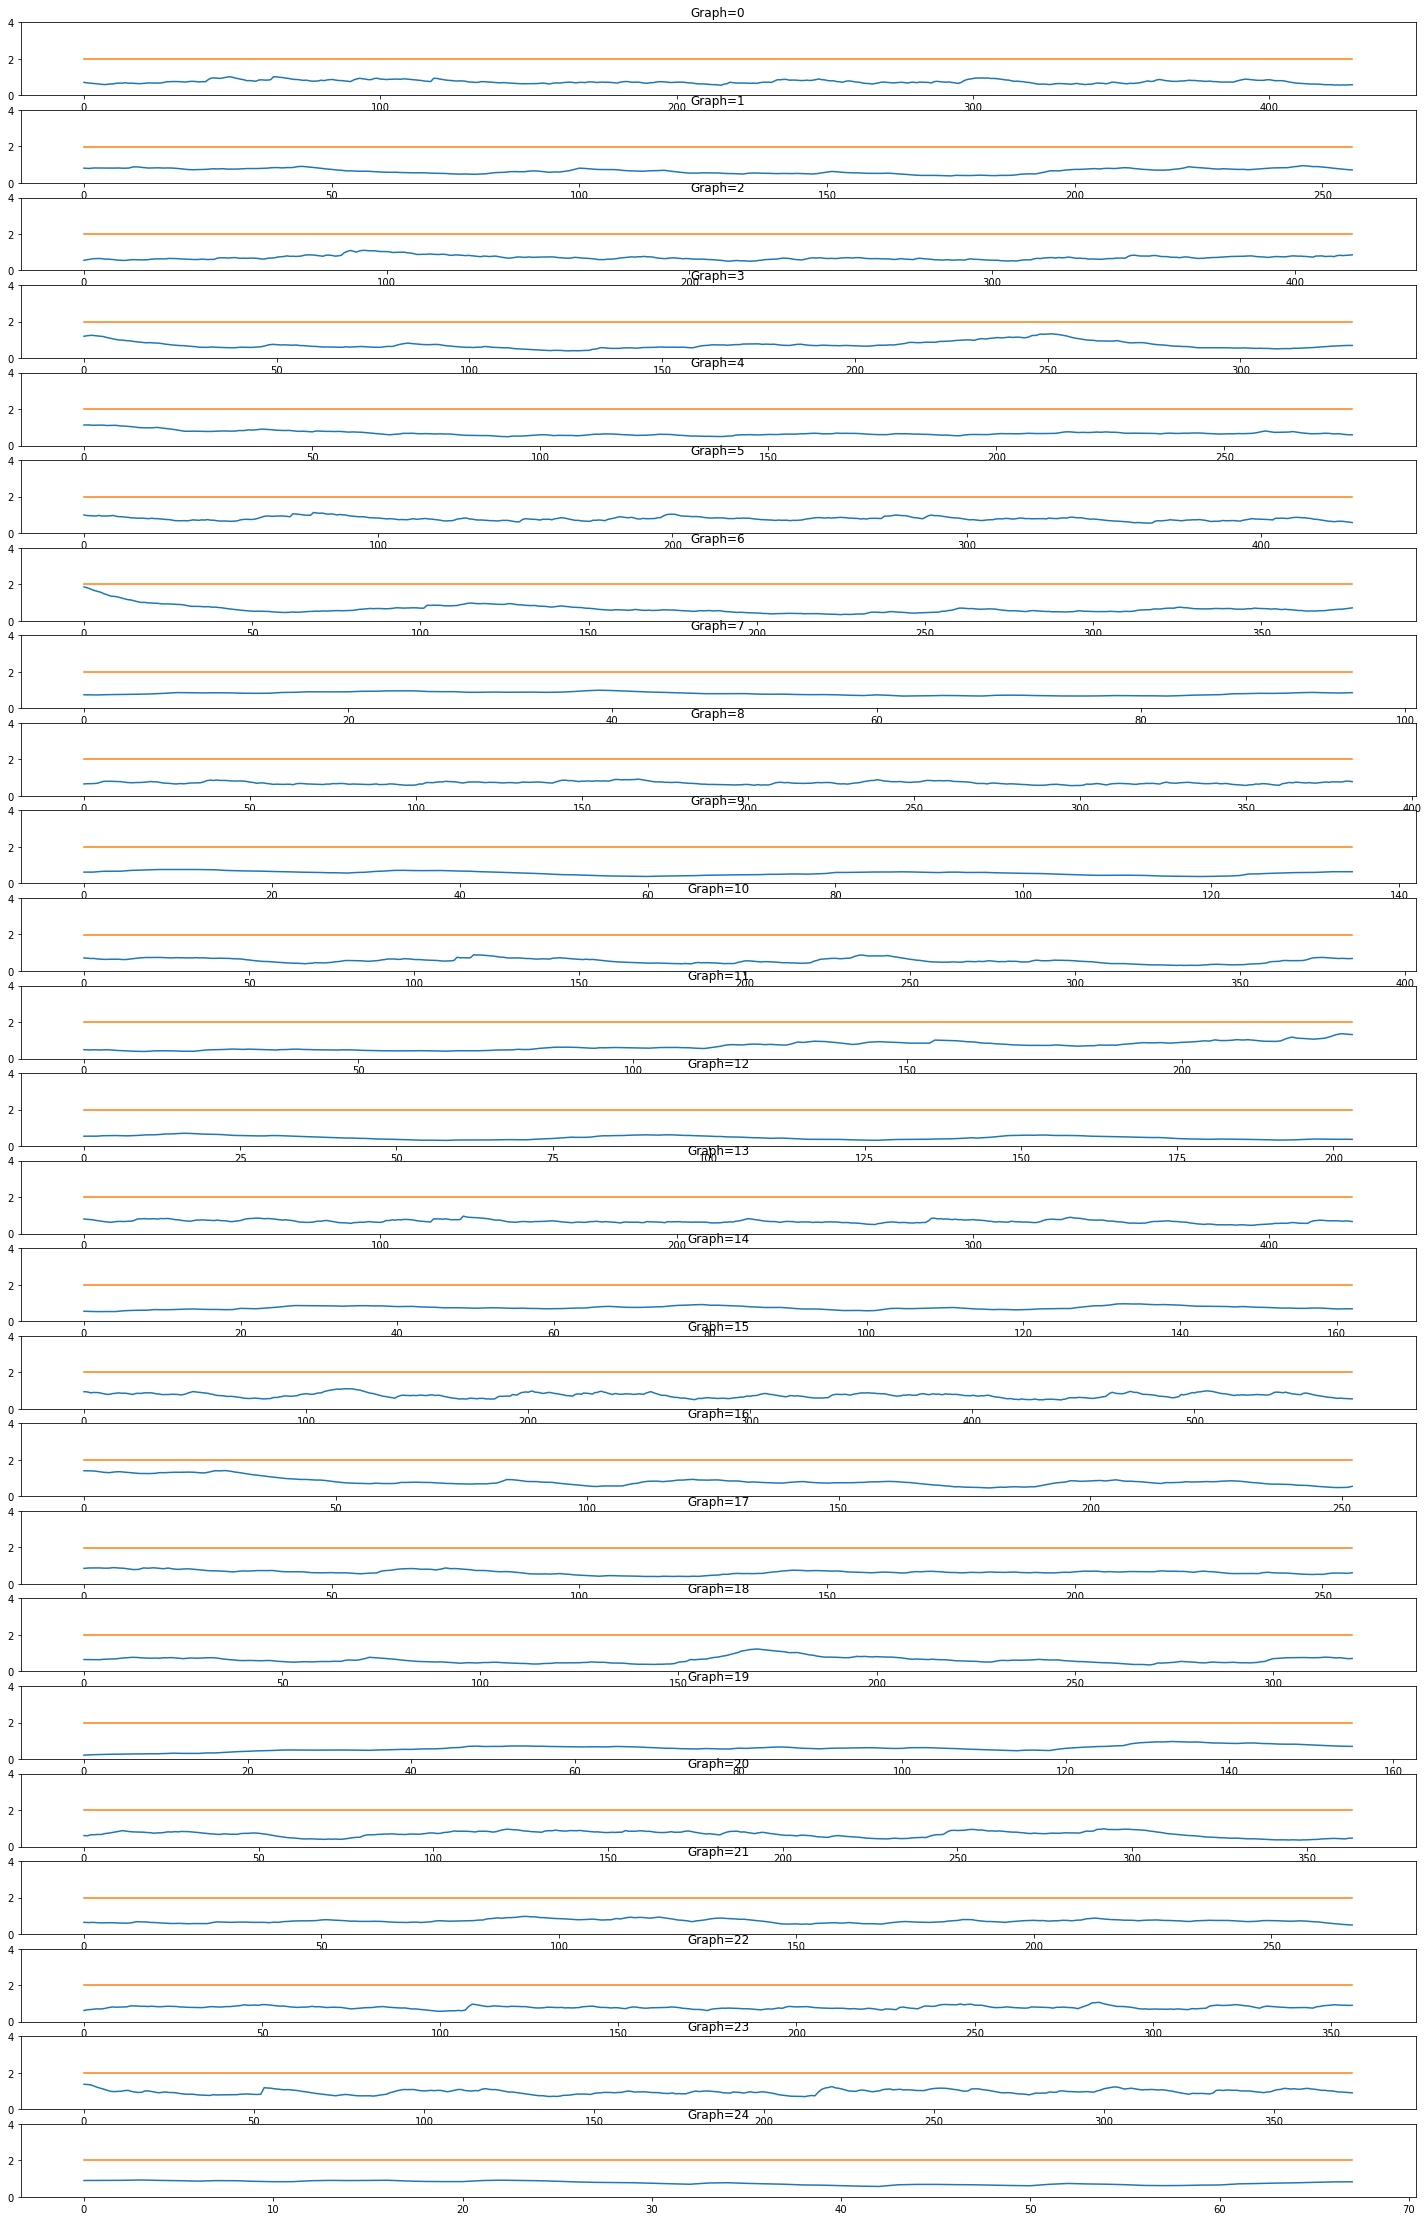

In [28]:
# Normal set

normal_pred = model.predict(normal_X)
time_start = time.process_time()
normal_residual = find_residual(normal_pred, normal_Y, normal_num, normal_seq_length, beta)
time_elapsed = (time.process_time() - time_start)
time_for_one_prediction = time_elapsed/7144
plot_normal_residual(normal_num, normal_seq_length, normal_residual, Threshold, (25, 40))

In [29]:
time_for_one_prediction # in seconds

6.561450167973124e-06

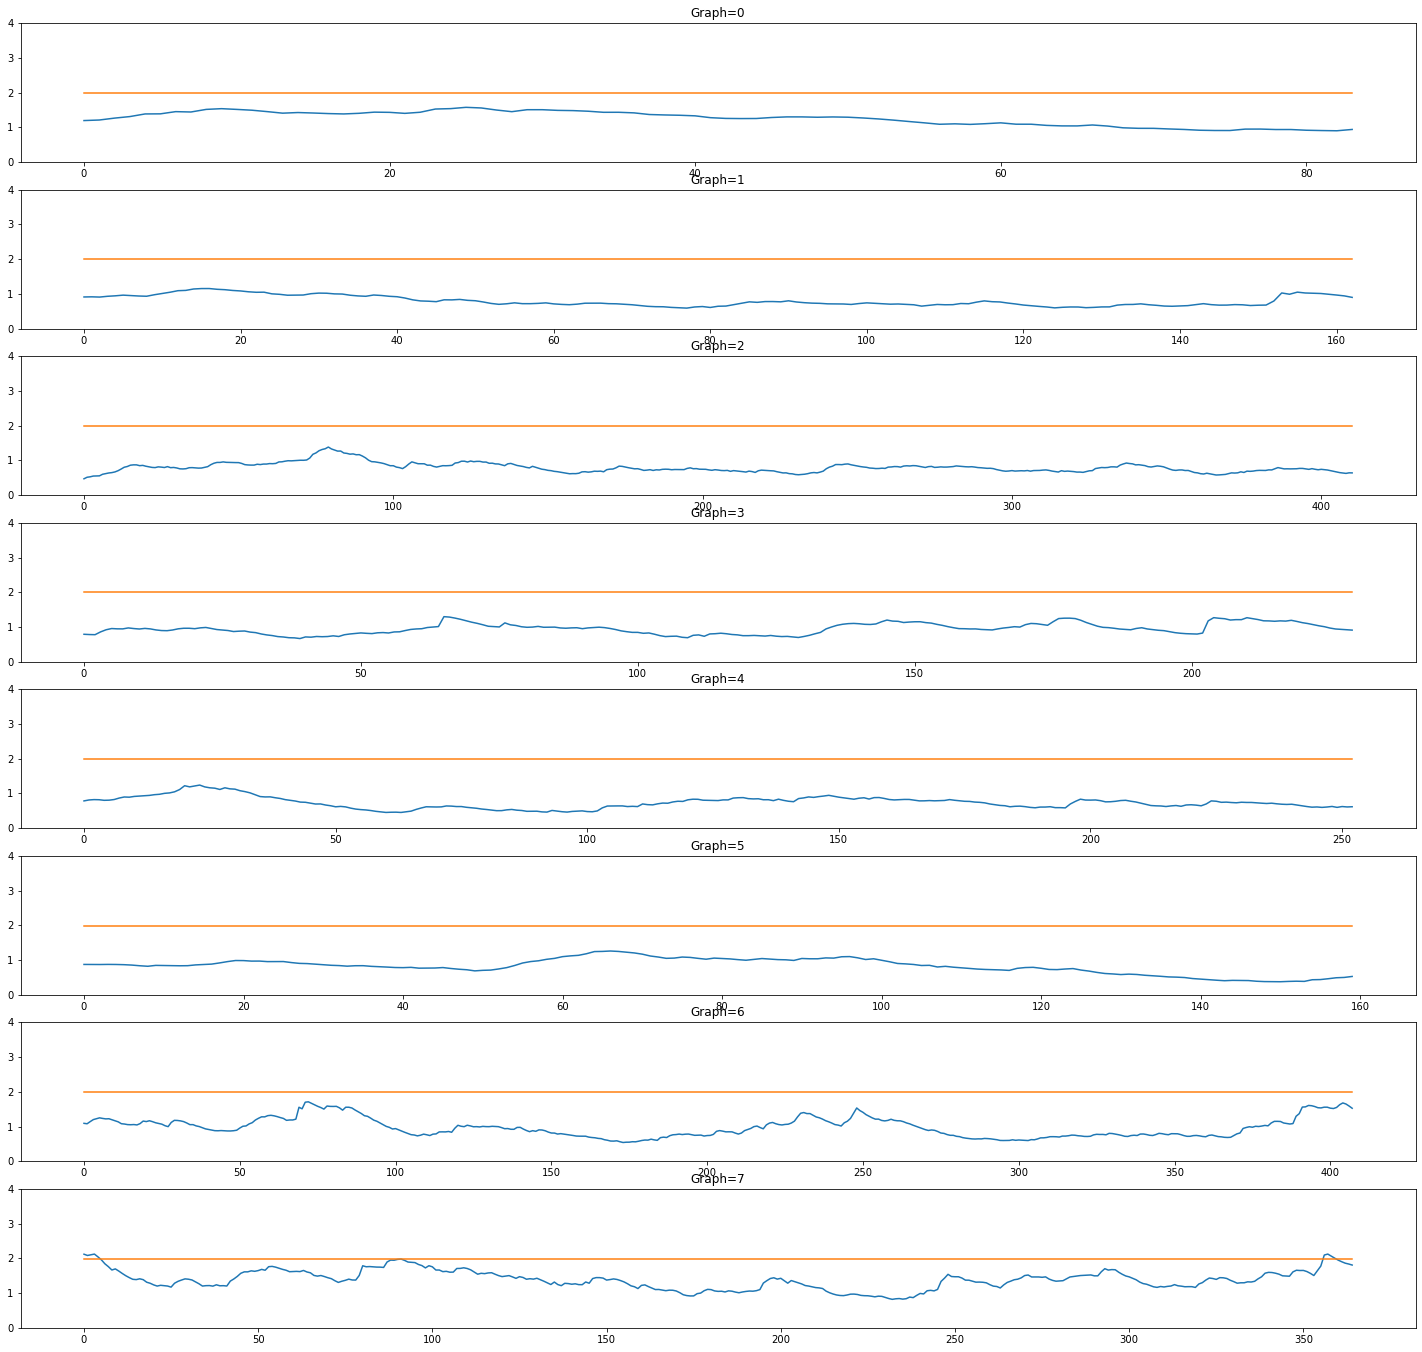

In [30]:
# Valid set
plot_normal_residual(valid_num, valid_seq_length, valid_residual, Threshold, (25, 24))

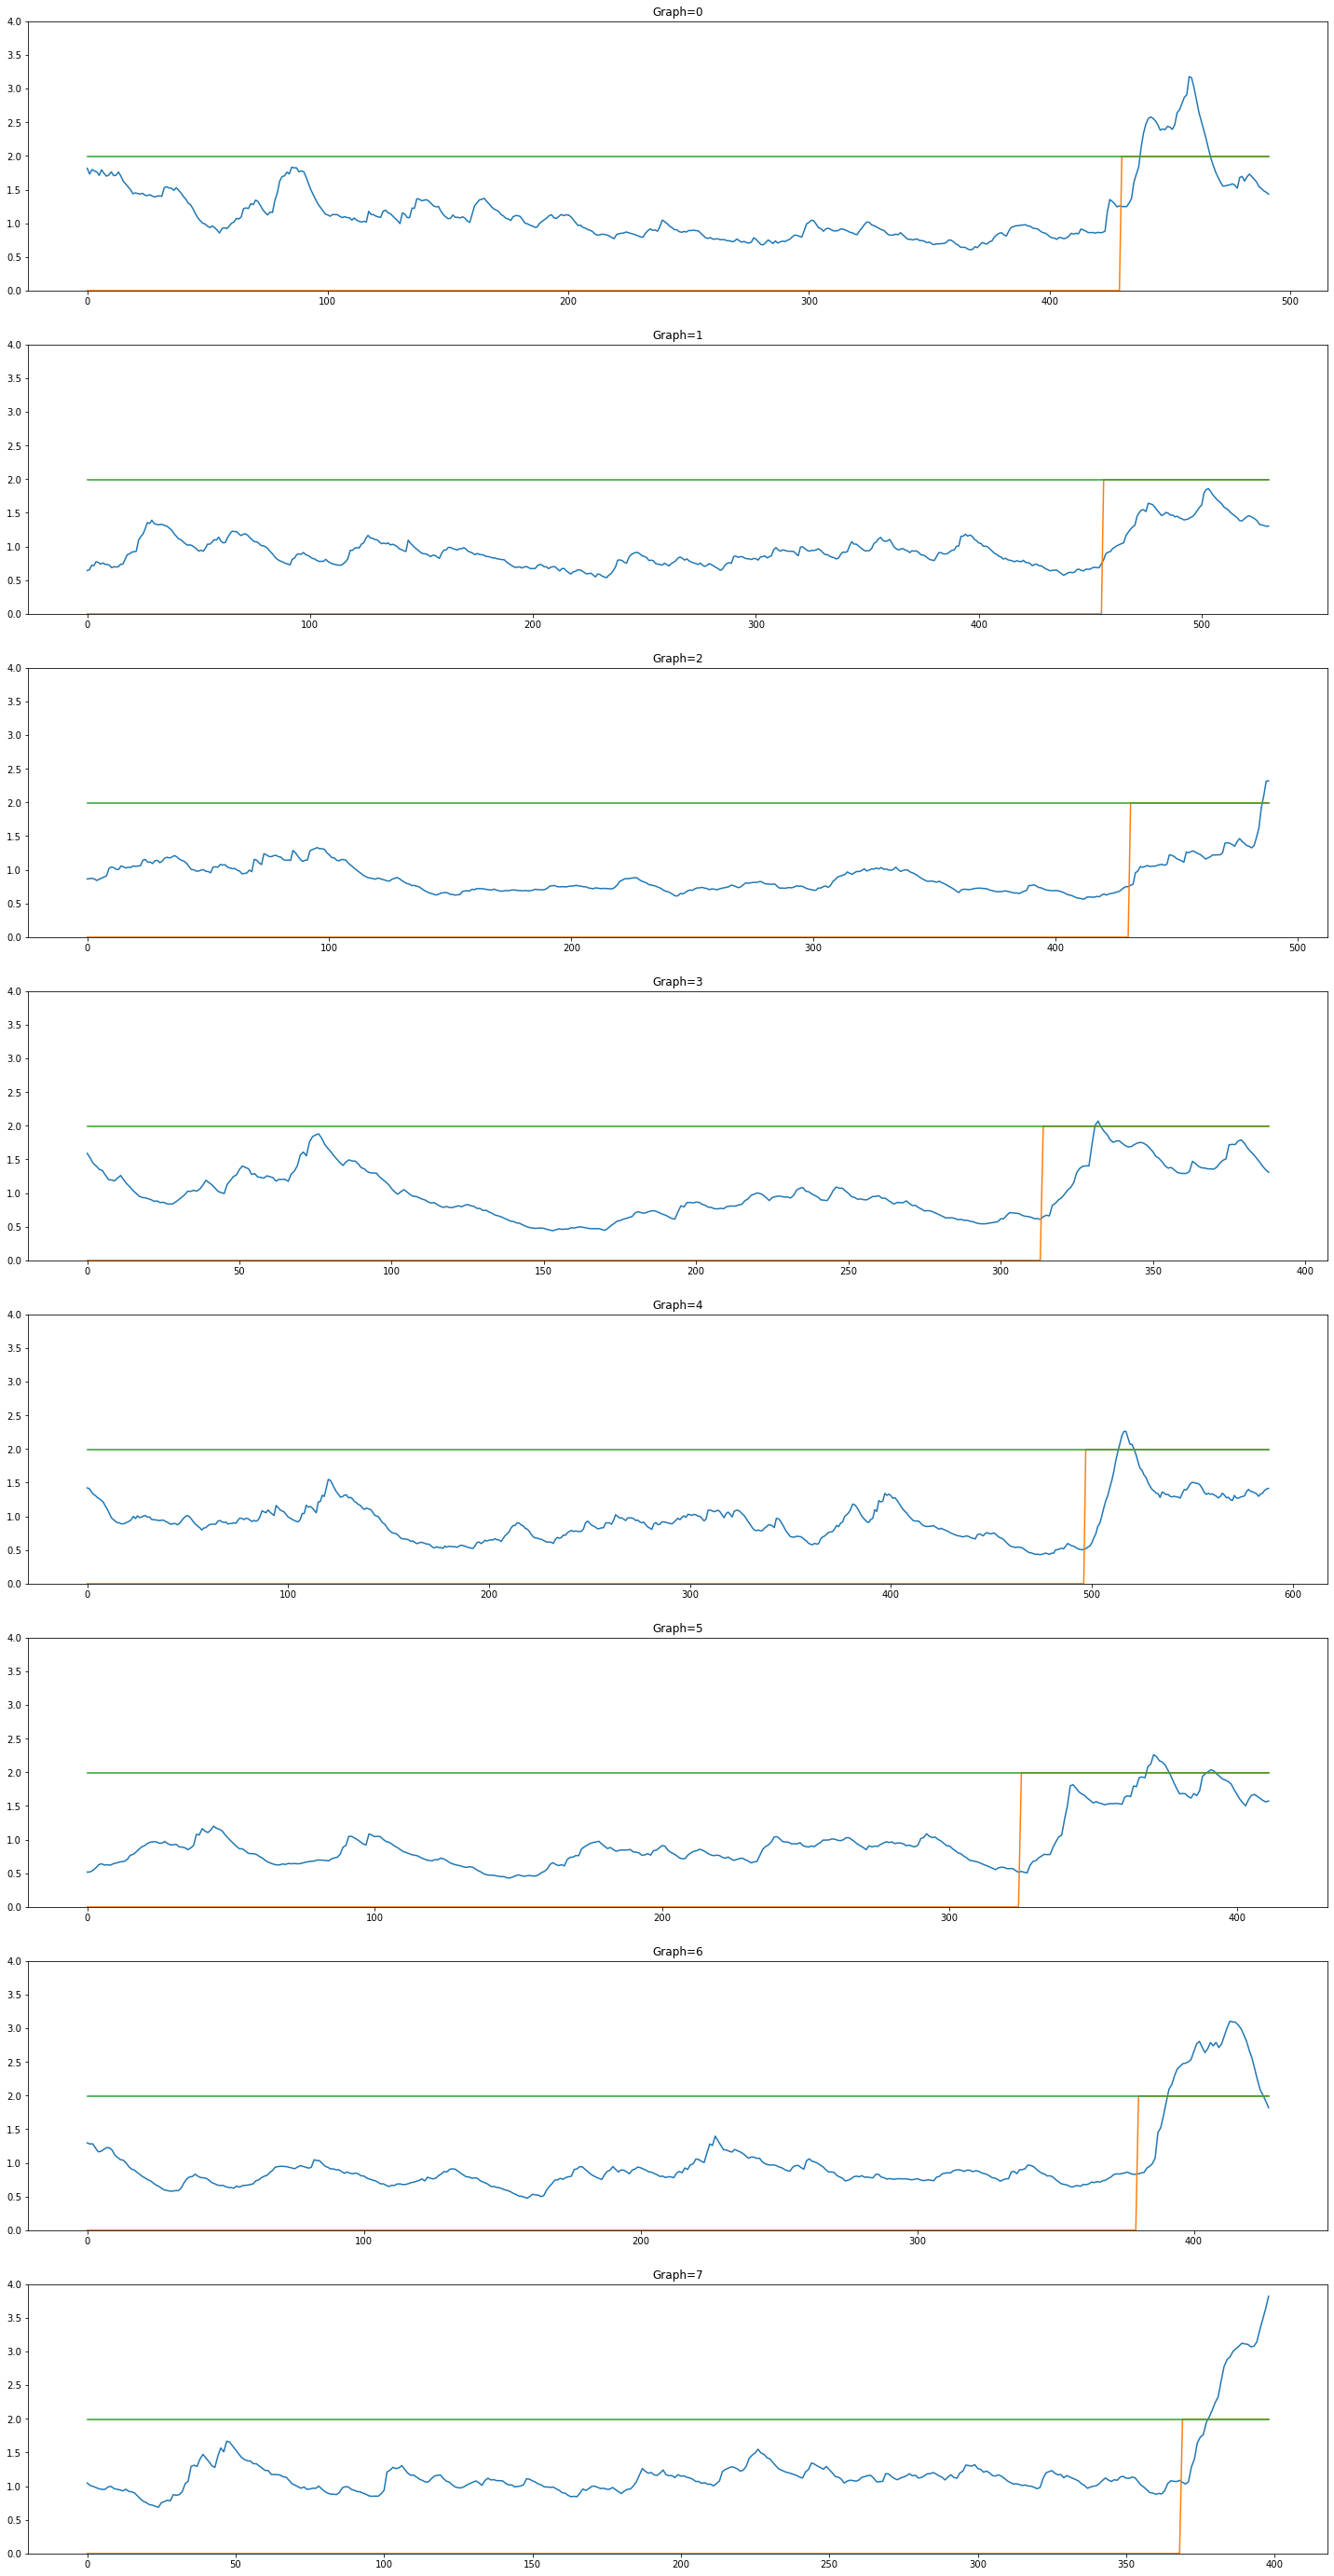

In [31]:
# Engine fault
engine_pred = model.predict(engine_X)
engine_residual = find_residual(engine_pred, engine_Y, engine_num, engine_seq_length, beta)
plot_fault_residual(engine_num, engine_seq_length, engine_residual, engine_label, Threshold, (25, 50))

In [120]:
# Save engine fault plot in .txt
save_plot_fault_residual(engine_num, engine_seq_length, engine_residual, engine_label, Threshold, 7)

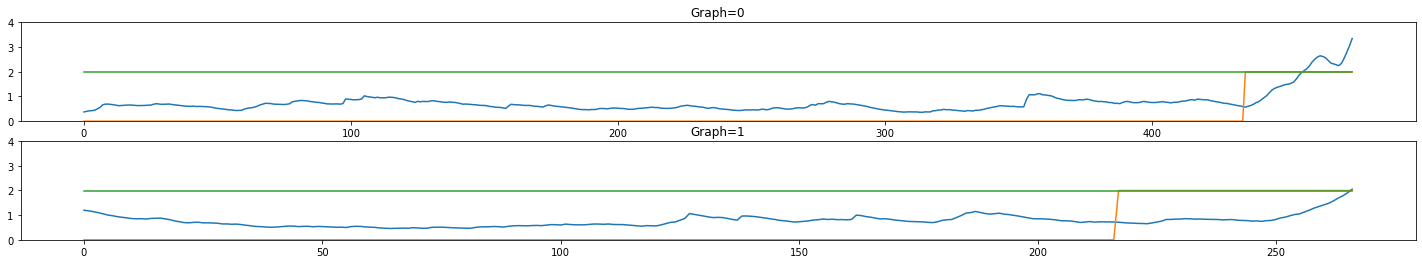

In [32]:
# Elevator fault
elevator_pred = model.predict(elevator_X)
elevator_residual = find_residual(elevator_pred, elevator_Y, elevator_num, elevator_seq_length, beta)
plot_fault_residual(elevator_num, elevator_seq_length, elevator_residual, elevator_label, Threshold, (25, 4))

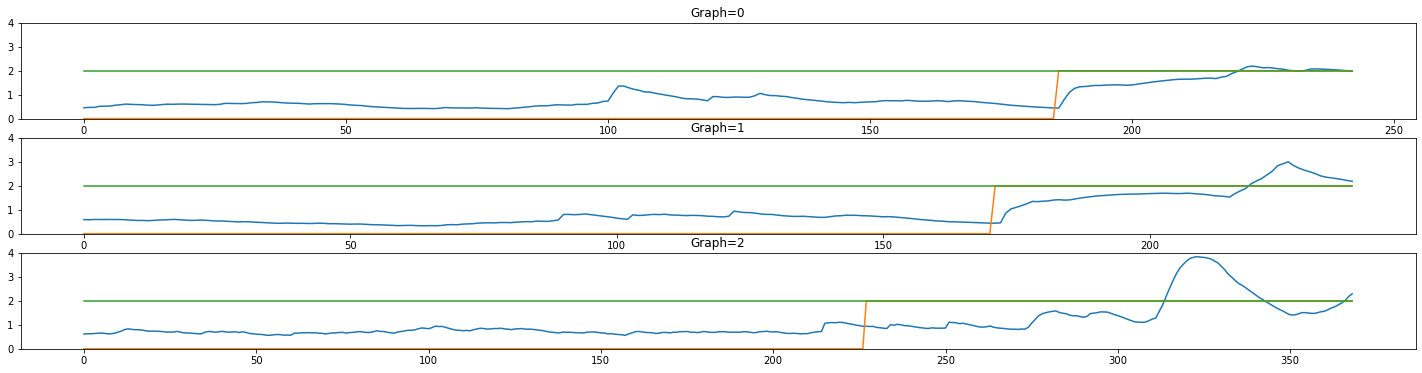

In [33]:
# Rudder fault
rudder_pred = model.predict(rudder_X)
rudder_residual = find_residual(rudder_pred, rudder_Y, rudder_num, rudder_seq_length, beta)
plot_fault_residual(rudder_num, rudder_seq_length, rudder_residual, rudder_label, Threshold, (25, 6))

# 4. The stacked LSTM with only one output

## 4.1 Find beta

In [127]:
model = keras.models.load_model('20220113_L=4_model.47-0.1205.h5')

In [136]:
def find_residual_for_beta(pred, Y, num, seq_length, beta):
    a, b = pred.shape
    residual = np.zeros((a,11)) # total state (1), velocity (3), attitude (4), angular velocity (3)
    index = 0
    for i in range(num):
        for j in range(seq_length[i] - window):
            difference = Y[index,:] - pred[index,:]
            if j == 0:
                residual[index,0] = np.linalg.norm(difference)
                residual[index,1:] = np.absolute(difference)
            else:
                residual[index,0] = beta * residual[index-1,0] + (1-beta)*np.linalg.norm(difference)
                residual[index,1:] = beta * residual[index-1,1:] + (1-beta)*np.absolute(difference)
            index = index + 1
    return residual 

In [248]:
# Find the best beta
length = 271
beta_list = np.zeros(length)
Threshold_list = np.zeros((length,11))
T_re = np.zeros((length,11))
for i in range(length):
    beta_list[i] = 0.7 + 0.001*i
    valid_pred = model.predict(valid_X)
    valid_residual = find_residual_for_beta(valid_pred, valid_Y, valid_num, valid_seq_length, beta_list[i])
    Threshold_list[i,:] = np.mean(valid_residual, axis=0) + 3.291 * np.std(valid_residual, axis=0)
    max_residual = np.max(valid_residual, axis=0)
    T_re[i,:] = np.abs(Threshold_list[i,:] - max_residual)

In [249]:
argmin = np.zeros(11)
beta = np.zeros(11)
for i in range(11):
    argmin[i] = float(np.argwhere((T_re[:,i]==np.min(T_re[:,i]))))
    beta[i] = beta_list[int(argmin[i])]

In [250]:
beta # final beta

array([0.916, 0.891, 0.939, 0.97 , 0.94 , 0.97 , 0.936, 0.906, 0.95 ,
       0.963, 0.97 ])

## 4.2 See the performances

In [406]:
def find_residual(pred, Y, num, seq_length):
    a, b = pred.shape
    residual = np.zeros((a,11)) # total state (1), velocity (3), attitude (4), angular velocity (3)
    index = 0
    for i in range(num):
        for j in range(seq_length[i] - window):
            difference = Y[index,:] - pred[index,:]
            if j == 0:
                residual[index,0] = np.linalg.norm(difference)
                residual[index,1:] = np.absolute(difference)
            else:
                residual[index,0] = beta[0] * residual[index-1,0] + (1-beta[0])*np.linalg.norm(difference)
                residual[index,1:] = beta[1:] * residual[index-1,1:] + (1-beta[1:])*np.absolute(difference)
            index = index + 1
    return residual 

def find_detection_time(num, seq_length, residual, label, Threshold, state_num):
    engine_label2 = np.sum(label[:,1:], axis=1)
    index = 0
    fault_start_index = np.zeros(num)
    fault_detect_index = np.zeros(num)
    for i in range(num):
        piece_residual = residual[index : index + seq_length[i] - window, state_num]
        piece_label = engine_label2[index : index + seq_length[i] - window]
        fault_indices = np.where(piece_label == 1)
        fault_start_index[i] = fault_indices[0][0]
        piece_check = np.where(piece_residual[np.int(fault_start_index[i]):] > Threshold[state_num])
        if piece_check[0].size >0:
            fault_detect_index[i] = piece_check[0][0] + fault_start_index[i]
        index = index + seq_length[i] - window
    return fault_start_index, fault_detect_index

def plot_normal_residual_totalstate(num, seq_length, residual, Threshold, figure_size):
    fig, axs = plt.subplots(num, figsize=figure_size)
    index = 0
    for i in range(num):
        axs[i].set(ylim=(0, 4))
        axs[i].set_xlabel('time(s)')
        axs[i].set_ylabel('Residual')
        axs[i].plot(0.25 * np.array(range(seq_length[i] - window)), residual[index : index + seq_length[i] - window, 0],
                    0.25 * np.array(range(seq_length[i] - window)), Threshold[0]*np.ones(seq_length[i] - window))
#        axs[i].set_title('Graph=' + str(i))
        index = index + seq_length[i] - window
        
def plot_fault_residual_totalstate(num, seq_length, residual, label, Threshold, figure_size):
    engine_label2 = np.sum(label[:,1:], axis=1)
    fig, axs = plt.subplots(num, figsize=figure_size)
    index = 0
    for i in range(num):
        axs[i].set(ylim=(0, 4))
        axs[i].set_xlabel('time(s)')
        axs[i].set_ylabel('Residual')
        axs[i].plot(0.25 * np.array(range(seq_length[i] - window)), residual[index : index + seq_length[i] - window, 0], 
                    0.25 * np.array(range(seq_length[i] - window)), Threshold[0]*engine_label2[index : index + seq_length[i] - window],
                    0.25 * np.array(range(seq_length[i] - window)), Threshold[0]*np.ones(seq_length[i] - window))
#        axs[i].set_title('Graph=' + str(i))
        index = index + seq_length[i] - window
        
# One state
state_index = 2 # Index number of the output
# 1:x-vel, 2:y-vel, 3:z-vel, 4: real part, 5,6,7: imaginary part, 8:roll rate, 9: pitch rate, 10: yaw rate
def plot_normal_residual_onestate(num, seq_length, residual, Threshold, figure_size):
    fig, axs = plt.subplots(num, figsize=figure_size)
    index = 0
    for i in range(num):
        axs[i].set(ylim=(0, Threshold[state_index]*1.5))
        axs[i].set_xlabel('time(s)')
        axs[i].set_ylabel('Residual')
        axs[i].plot(0.25 * np.array(range(seq_length[i] - window)), residual[index : index + seq_length[i] - window, state_index],
                    0.25 * np.array(range(seq_length[i] - window)), Threshold[state_index]*np.ones(seq_length[i] - window))
#        axs[i].set_title('Graph=' + str(i))
        index = index + seq_length[i] - window
        
def plot_fault_residual_onestate(num, seq_length, residual, label, Threshold, figure_size):
    engine_label2 = np.sum(label[:,1:], axis=1)
    fig, axs = plt.subplots(num, figsize=figure_size)
    index = 0
    for i in range(num):
        axs[i].set(ylim=(0, Threshold[state_index]*1.5))
        axs[i].set_xlabel('time(s)')
        axs[i].set_ylabel('Residual')
        axs[i].plot(0.25 * np.array(range(seq_length[i] - window)), residual[index : index + seq_length[i] - window, state_index], 
                    0.25 * np.array(range(seq_length[i] - window)), Threshold[state_index]*engine_label2[index : index + seq_length[i] - window],
                    0.25 * np.array(range(seq_length[i] - window)), Threshold[state_index]*np.ones(seq_length[i] - window))
#        axs[i].set_title('Graph=' + str(i))
        index = index + seq_length[i] - window
    
def save_plot_fault_residual_onestate(num, seq_length, residual, label, Threshold, plot_num):
    engine_label2 = np.sum(label[:,1:], axis=1)
    index = 0
    for i in range(num):
        if i == plot_num:
            np.savetxt('fault_one.txt', np.concatenate((np.expand_dims(0.25*np.array(range(seq_length[i] - window)), axis=1), 
                                                   np.expand_dims(residual[index : index + seq_length[i] - window, state_index], axis=1),
                                                   np.expand_dims(np.array(Threshold[state_index]*engine_label2[index : index + seq_length[i] - window]), axis=1),
                                                   np.expand_dims(Threshold[state_index]*np.ones(seq_length[i] - window), axis=1)), axis=1), delimiter=',')
                                                  
        index = index + seq_length[i] - window

In [407]:
# Find Threshold

valid_pred = model.predict(valid_X)
valid_residual = find_residual(valid_pred, valid_Y, valid_num, valid_seq_length)
Threshold = np.mean(valid_residual, axis=0) + 3.291 * np.std(valid_residual, axis=0)
print(Threshold)

[1.99414383 0.46993537 0.48380765 0.85361801 0.40388796 0.39463801
 0.27315779 0.31080383 1.07332631 0.5561803  0.81196088]


## Normal set

## Valid set

## Engine fault set

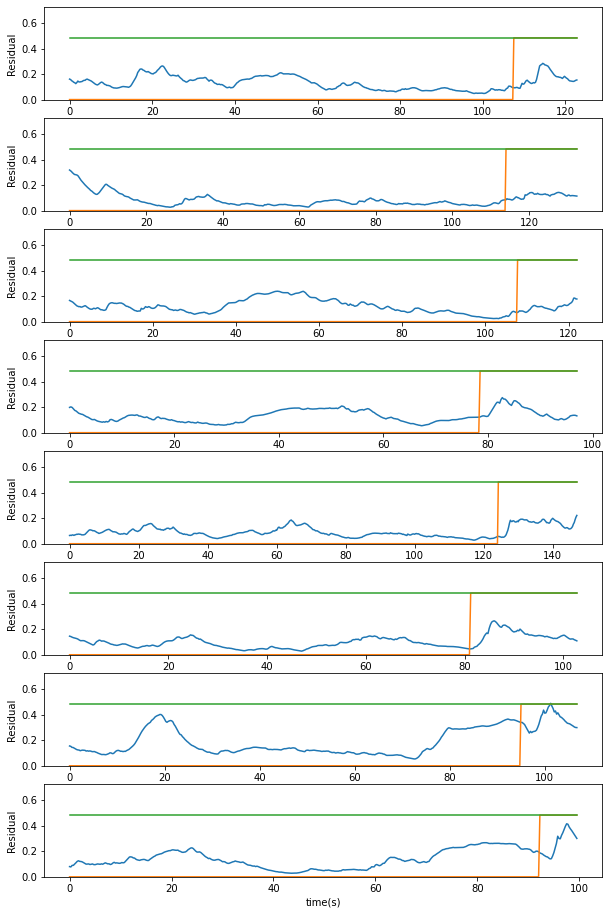

In [408]:
# Engine fault one state
engine_pred = model.predict(engine_X)
engine_residual = find_residual(engine_pred, engine_Y, engine_num, engine_seq_length)
plot_fault_residual_onestate(engine_num, engine_seq_length, engine_residual, engine_label, Threshold, (10, 16))

In [409]:
# Save engine fault plot in .txt
save_plot_fault_residual_onestate(engine_num, engine_seq_length, engine_residual, engine_label, Threshold, 3)

## Elevator fault set

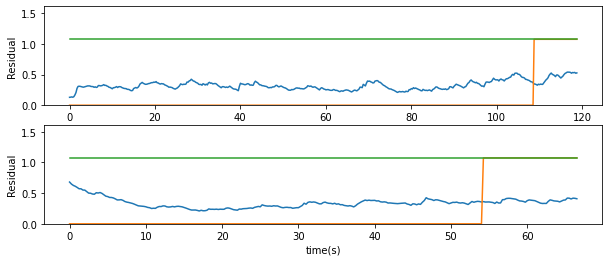

In [398]:
elevator_pred = model.predict(elevator_X)
elevator_residual = find_residual(elevator_pred, elevator_Y, elevator_num, elevator_seq_length)
plot_fault_residual_onestate(elevator_num, elevator_seq_length, elevator_residual, elevator_label, Threshold, (10, 4))

## Rudder fault set

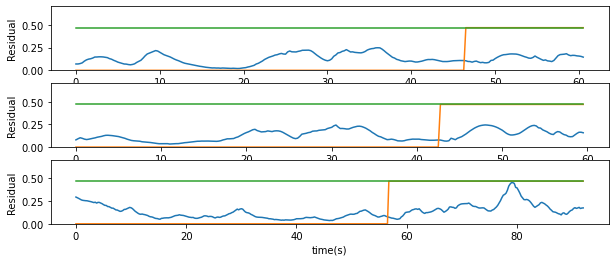

In [389]:
rudder_pred = model.predict(rudder_X)
rudder_residual = find_residual(rudder_pred, rudder_Y, rudder_num, rudder_seq_length)
plot_fault_residual_onestate(rudder_num, rudder_seq_length, rudder_residual, rudder_label, Threshold, (10, 4))

# 5. Response time

In [390]:
def find_detection_time(num, seq_length, residual, label, Threshold, state_num):
    engine_label2 = np.sum(label[:,1:], axis=1)
    index = 0
    fault_start_index = np.zeros(num)
    fault_detect_index = np.zeros(num)
    for i in range(num):
        piece_residual = residual[index : index + seq_length[i] - window, state_num]
        piece_label = engine_label2[index : index + seq_length[i] - window]
        fault_indices = np.where(piece_label == 1)
        fault_start_index[i] = fault_indices[0][0]
        piece_check = np.where(piece_residual[np.int(fault_start_index[i]):] > Threshold[state_num])
        if piece_check[0].size >0:
            fault_detect_index[i] = piece_check[0][0] + fault_start_index[i]
        index = index + seq_length[i] - window
    return fault_start_index, fault_detect_index

In [379]:
state_num = state_index
engine_fault_start_index, engine_fault_detect_index = find_detection_time(engine_num, engine_seq_length, engine_residual, engine_label, Threshold, state_num)
elevator_fault_start_index, elevator_fault_detect_index = find_detection_time(elevator_num, 
                                                                              elevator_seq_length, elevator_residual, elevator_label, Threshold, state_num)
rudder_fault_start_index, rudder_fault_detect_index = find_detection_time(rudder_num, rudder_seq_length, rudder_residual, rudder_label, Threshold, state_num)
fault_start_index = np.concatenate((engine_fault_start_index, elevator_fault_start_index, rudder_fault_start_index))
fault_detect_index = np.concatenate((engine_fault_detect_index, elevator_fault_detect_index, rudder_fault_detect_index))
fault_start_index_TP = fault_start_index[fault_detect_index > 0]
fault_detect_index_TP = fault_detect_index[fault_detect_index > 0]
fault_detection_time = 0.25 * (fault_detect_index_TP - fault_start_index_TP)

print(fault_detection_time)
print(np.mean(fault_detection_time))

[ 7.25  8.25 25.25]
13.583333333333334
